Since we have concluded our batting order in Sheet 1 , lets check if our prediction is correct by doing 
Posterior predictive checks

In [44]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

Read the data set of 9 players whose batting order was predicted in Sheet1.

In [45]:
baseball_game = pd.read_csv('data/BattingOrder_players.csv')
baseball_game

,Name,WAR,OPS,ISO,HR,RBI,wOBA,Runs
0,Mookie Battes,10.4,1.078,0.294,32,80,0.449,129
1,J.D.Martinez,5.9,1.031,0.229,43,130,0.427,111
2,Xander Bogarts,4.9,0.882,0.234,23,103,0.373,72
3,Steve Pearce,1.2,0.901,0.228,7,26,0.387,19
4,Rafael Devers,1.0,0.731,0.193,21,66,0.310,66
5,Andrew Benintendi,4.3,0.831,0.174,16,87,0.357,103
6,Mitch Morland,0.6,0.758,0.188,15,68,0.325,57
7,Jackie Bradley Jr,2.8,0.717,0.169,13,59,0.310,76
8,Brock Holt,1.4,0.773,0.134,7,46,0.338,41


In [5]:
name1, war1, ops1,iso1 , hr1, rbi1, woba1, runs1,  = baseball_game.T.values
name1, war1, ops1, runs1

(array(['Mookie Battes', 'J.D.Martinez', 'Xander Bogarts', 'Steve Pearce',
        'Rafael Devers', 'Andrew Benintendi', 'Mitch Morland',
        'Jackie Bradley Jr', 'Brock Holt'], dtype=object),
 array([10.4, 5.9, 4.9, 1.2, 1.0, 4.3, 0.6, 2.8, 1.4], dtype=object),
 array([1.078, 1.031, 0.882, 0.9009999999999999, 0.731, 0.831, 0.758,
        0.7170000000000001, 0.773], dtype=object),
 array([129, 111, 72, 19, 66, 103, 57, 76, 41], dtype=object))

Priors:

The first step in specifying our model is to specify priors for our model.

Recall we use a linear model for μ, with an intercept (bias) factor and two linear factors slope1 and slope2 to represent our hyperparametes WAR,HR,OPS,ISO,WOBA,RBI 

μ=intercept+slope1∗x+slope2∗z
 
We are going to model these factors as normal distributions with a wide support:

∼Normal(0,100)
∼Normal(0,100)
 
and finally the standard deviation of our modelled Points will be a half Cauchy:

σ∼HalfCauchy(1)
σ∼HalfCauchy(1)
 
The half-Cauchy distribution (half of a Cauchy) has support over positive continuous values, and relatively large tail probabilities, allowing for the possibility of extreme values. It is a very often used modeling pdf.

Since we want to track slopes, we need to add them as deterministic variables of our model: pm.Deterministic.



In [18]:
from pymc3 import Normal, HalfCauchy, Deterministic, Model
import theano.tensor as tt

with Model() as run_model:
    
    intercept = Normal('intercept', 0, sd=100)
    slope1 = Normal('slope1', 0, sd=100)
    slope2 = Normal('slope2', 0, sd=100)
    slope3 = Normal('slope3', 0, sd=100)
    slope4 = Normal('slope4', 0, sd=100)
    slope5 = Normal('slope5', 0, sd=100)
    slope6 = Normal('slope6', 0, sd=100)
    war_prior = Deterministic('war_prior', slope1)
    ops_prior = Deterministic('ops_prior', slope2)
    iso_prior = Deterministic('iso_prior', slope3)
    woba_prior = Deterministic('woba_prior', slope4)
    rbi_prior = Deterministic('rbi_prior', slope5)
    hr_prior = Deterministic('hr_prior', slope6)
    σ = HalfCauchy('σ', 1)

In [19]:
with run_model:
    
    μ = intercept + slope1*baseball_game.WAR + slope2*baseball_game.OPS + slope3*baseball_game.ISO + slope4*baseball_game.wOBA  + slope5*baseball_game.RBI  + slope6*baseball_game.HR
    points = Normal('points', μ, sd=σ, observed=baseball_game.Runs)
   

All right! Now our regression model is fully specified and we are ready to track your posteriors.

You can now use the fitting method of our choice to estimate a posterior distribution. Let's use a Markov chain Monte Carlo algorithm, called NUTS (the No U-Turn Sampler).

In [20]:
from pymc3 import sample

with run_model:

    game_sample = sample(1000, random_seed=RANDOM_SEED)

    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, hr_prior, rbi_prior, woba_prior, iso_prior, ops_prior, war_prior, intercept]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:39<00:00, 152.93draws/s]
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7215201992050717, but should be close to 0.8. Try to increase the number of tuning steps.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7151819656960438, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


We get our posteriors of hyperparameters in above step, now let's plot them

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABACEFCA90>,
      dtype=object)

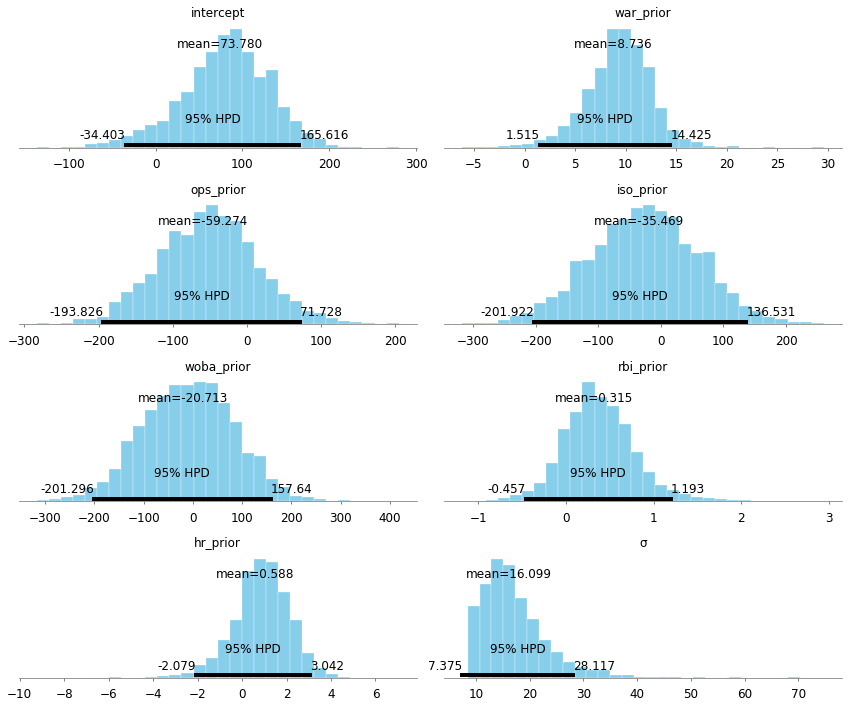

In [46]:
from pymc3 import plot_posterior

#plot_posterior(game_sample[500:], varnames=['intercept', 'ops_prior', 'war_prior', 'σ']);
plot_posterior(game_sample)

In [22]:
game_sample

<MultiTrace: 4 chains, 1000 iterations, 15 variables>

Lets check our model by doing the Posterior prediction check 

In [40]:
from pymc3 import sample_ppc

with run_model:
    
    game_ppc = sample_ppc(game_sample,1000)

100%|██████████| 1000/1000 [00:01<00:00, 572.99it/s]


In [41]:
game_ppc['points'].shape

(1000, 9)

In [42]:
game_points = game_ppc['points'].T
game_points

array([[186.97231539,  75.00524259, 119.94733101, ..., 135.86753036,
        130.11806108, 114.01524754],
       [136.16291758, 115.40832634, 105.31090522, ...,  93.56559446,
         96.73550606,  95.48383455],
       [ 93.07092005, 123.07702064,  93.7134089 , ...,  96.60786948,
         92.65157388,  81.88324146],
       ...,
       [ 59.47635327,  45.86890938,  35.68200362, ...,  62.68607148,
         55.83906855,  50.47374326],
       [ 33.37967615,  92.80712618,  62.4409294 , ...,  94.91806168,
         74.37409438,  98.97663939],
       [ 10.87038033,  46.77406937,  47.79790003, ...,  32.91588798,
         47.29907003,  50.00928666]])

Compare the real data (our data set) with the ppc/simulated data and plot the runs (our hidden/latent parameter)

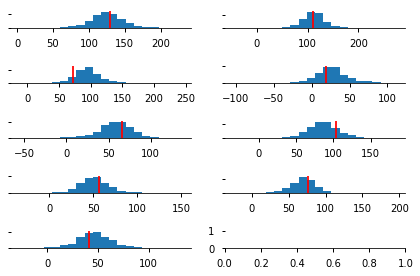

In [47]:
game_ppc = fig, axes = plt.subplots(5, 2)
axes_flat = axes.flatten()

for ax, real_data, sim_data in zip(axes_flat[:], runs1, game_points):
    ax.hist(sim_data, bins=20)
    ax.vlines(real_data, *ax.get_ylim(), colors='red')
    ax.set_yticklabels([])
    sns.despine(left=True)

plt.tight_layout()

ok , so the runs are plotted fine on the sampled data 

In [37]:
game_points

array([[147.54960401, 115.9401065 , 129.2228489 , ..., 114.76173155,
        150.42140656, 116.66353253],
       [137.1288538 , 121.63948065,  34.51273272, ..., 109.45490714,
        111.96963522, 101.00482929],
       [137.18013223,  85.13666411, 136.14968269, ..., 147.91076932,
         96.05234998, 103.69986041],
       ...,
       [ 17.65037821,  56.4002094 ,  34.12541272, ...,  65.50359182,
         48.79469644,  39.5638621 ],
       [ 56.05764977,  67.55423943,  78.1381892 , ...,  61.85448795,
         98.43242758,  59.6860927 ],
       [ 45.41802306,  28.07727551,  33.31673133, ...,  80.91860212,
         60.45389983,  50.1796851 ]])

Now, lets take the mean of all the sampled PPC data (our PPC simulated data contains the samples of runs of all the 9 predicted players)

In [43]:
sum_all_points = sum(game_ppc['points'])
avg_all_points = sum_all_points/1000
avg_all_points

array([125.21665966, 111.91465434,  95.01574832,  26.69248462,
        58.49892117,  85.98016627,  51.58486153,  69.83367291,
        47.27742946])

We observe the avergae of all the players and realize that maybe our prediction of players in sheet 1 is a bit incorrect